# Validate Minian outputs

## Load the required packages

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
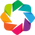

In [1]:
import numpy as np
import csv
from pathlib import Path
import xarray as xr
import pandas as pd
from pandas import concat
import matplotlib.pyplot as plt
import itertools as itt
import os
import sys
import json
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.stats import zscore
from scipy import stats
import cv2
import holoviews as hv
import panel as pn
import param
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from holoviews import opts
from holoviews import Store
from holoviews.operation.datashader import shade
hv.extension('bokeh', 'matplotlib')
#from IPython.core.display import display
from IPython.display import display
from ipyfilechooser import FileChooser
%matplotlib widget


import warnings
warnings.filterwarnings("ignore")
#%reset

In [2]:
minian_path = os.path.join(os.path.abspath('..'),'minian')
print("The folder used for minian procedures is : {}".format(minian_path))

sys.path.append(minian_path)
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

The folder used for minian procedures is : c:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian


## Import minian files

Select the folder

In [3]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Aurelie\CheeseboardExperiment\DAQ_data\AB\Training\Lou\Che…

In [48]:
minianversion = 'minian'
try: # tries to retrieve minianversion either from a previous run or from a previous notebook
    %store -r minianversion
except:
    print("the minian folder to use was not defined in store")
    minianversion = 'minian' #'minianAB' # or 'minian_intermediate'
    %store minianversion

folderMouse = Path(os.path.join(dpath,minianversion))
print(folderMouse)
minian_ds = open_minian(folderMouse)

A_original = minian_ds['A']
C_original = minian_ds['C']
S_original = minian_ds['S']

A = minian_ds['A']
C = minian_ds['C']
S = minian_ds['S']

idloc = A.idxmax("unit_id")
Hmax = A.idxmax("height")
Hmax2 = Hmax.max("width")

Wmax = A.idxmax("width")
Wmax2 = Wmax.max("height")
coord1 = Wmax2.to_series()
coord2 = Hmax2.to_series()

a_original = pd.concat([coord1,coord2], axis=1)
a = pd.concat([coord1,coord2], axis=1)
unit = len(a)
print("{} units have been found".format(unit))

no stored variable or alias minianversion
\\10.69.168.1\crnldata\forgetting\Clementine\CheeseboardExperiment\DAQ_data\ClementineR\Test\YL\SleepBefore\2025_03_17\11_39_24\My_V4_Miniscope\minian
71 units have been found


## Import miniscope video

Load miniscope raw frames

In [49]:
for files in os.listdir(Path(dpath)):
    if files.endswith(('.avi')):
        video_file = files 
        break
video_path = os.path.join(dpath, video_file)
print(video_path)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
heightV = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
widthV = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

# Initialize accumulator
avg_frame = np.zeros((heightV, widthV, 3), np.float32)

# Read and accumulate frames
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    avg_frame += frame.astype(np.float32)
    count += 1

cap.release()

# Compute the average frame
avg_frame /= count
avg_frame = avg_frame.astype(np.uint8)

\\10.69.168.1\crnldata\forgetting\Clementine\CheeseboardExperiment\DAQ_data\ClementineR\Test\YL\SleepBefore\2025_03_17\11_39_24\My_V4_Miniscope\0.avi


Increase contrast of the average frame if necessary

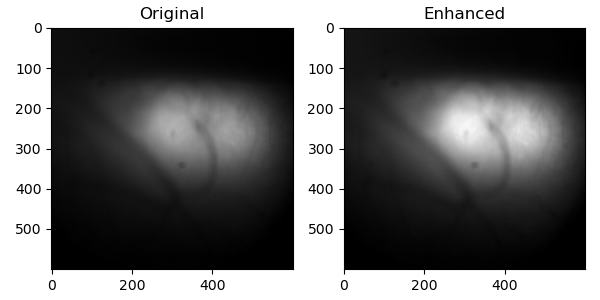

In [50]:
# Increase contrast and brightness
alpha = 1.4 # Contrast control (>1 increases contrast)
beta = 0   # Brightness control (>0 increases brightness)

enhanced_frame = cv2.convertScaleAbs(avg_frame, alpha=alpha, beta=beta)

# Convert BGR to RGB for Matplotlib
avg_frame_rgb = cv2.cvtColor(avg_frame, cv2.COLOR_BGR2RGB)
enhanced_frame_rgb = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(avg_frame_rgb)
axes[0].set_title("Original")
axes[1].imshow(enhanced_frame_rgb)
axes[1].set_title("Enhanced")
plt.tight_layout()
plt.show()

## Select units to drop/keep

Optional : load a previous 'TodropFileAB.json' file if it exists

In [33]:
TodropFile = folderMouse / f'TodropFileAB.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

A=A_original.drop_sel(unit_id=unit_to_drop)
C=C_original.drop_sel(unit_id=unit_to_drop)
S=S_original.drop_sel(unit_id=unit_to_drop)

idloc = A.idxmax("unit_id")
Hmax = A.idxmax("height")
Hmax2 = Hmax.max("width")

Wmax = A.idxmax("width")
Wmax2 = Wmax.max("height")
coord1 = Wmax2.to_series()
coord2 = Hmax2.to_series()

a = pd.concat([coord1,coord2], axis=1)
unit = len(a)
print("{} units remain".format(unit))

FileNotFoundError: [Errno 2] No such file or directory: '\\\\10.69.168.1\\crnldata\\forgetting\\Clementine\\CheeseboardExperiment\\DAQ_data\\ClementineR\\Test\\YL\\SleepBefore\\2025_03_17\\11_36_38\\My_V4_Miniscope\\minian\\TodropFileAB.json'

Plot the spatial map for all cells + interactive Ca2+ trace

In [51]:
# Define the actions triggered by drop/keep buttons
unit_to_keep=a.index.tolist()   

# Set up selector object
discrete_slider = pn.widgets.DiscreteSlider(
    name="Choose unit", 
    options=[i for i in a.index],
    value=a.index[0]
)
text_input = pn.widgets.TextInput(value='', width=300)

drop_unit_button = pn.widgets.Button(name='Drop this unit! >', button_type='primary')
keep_unit_button = pn.widgets.Button(name='Keep this unit!')
next_unit_button = pn.widgets.Button(name='Next unit > ', button_type='primary')
previous_unit_button = pn.widgets.Button(name='< Previous unit')


# Define a callback function for the button
def dropunit_callback(event):
    selected_value = discrete_slider.value
    text=f'Unit n°{selected_value} dropped!'
    number = selected_value
    if number in unit_to_keep:
        unit_to_keep.remove(number)
    nextunit_callback(event)
    text_input.value = text

# Define a callback function for the button
def keepunit_callback(event):
    selected_value = discrete_slider.value
    text=f'Unit n°{selected_value} kept!'
    number = selected_value
    if number not in unit_to_keep:
        unit_to_keep.append(number)
        unit_to_keep.sort()
    text_input.value = text

# Define a callback function for the button
def nextunit_callback(event):
    position = np.where(a.index == discrete_slider.value)[0]
    position = position[0]
    nextunitvalue=a.index[position + 1] if position+2<=len(a) else a.index[0]
    discrete_slider.value = nextunitvalue
    
# Define a callback function for the button
def previousunit_callback(event):
    position = np.where(a.index == discrete_slider.value)[0]
    position = position[0]
    previousunitvalue=a.index [position - 1]
    discrete_slider.value = previousunitvalue

drop_unit_button.on_click(dropunit_callback)
keep_unit_button.on_click(keepunit_callback)
next_unit_button.on_click(nextunit_callback)
previous_unit_button.on_click(previousunit_callback)

# Define interactivity
@pn.depends(indexes=discrete_slider)
def calciumtrace(indexes):
    index = indexes
    position = np.where(a.index == index)[0]
    position = position[0]
    return hv.Curve((C[position, :]), label=f'Unit n° {index}').opts(ylim=(-0.5, 10), frame_height=150, color='red')

@pn.depends(indexes=discrete_slider)
def circlepath(indexes):
    index = indexes
    radius = 15
    num_points=100
    theta = np.linspace(0, 2*np.pi, num_points)
    position = np.where(a.index == index)[0]
    position = position[0]
    return hv.Path((a.iloc[position, 0] + radius * np.cos(theta), a.iloc[position, 1] + radius * np.sin(theta)), group='keep').opts(ylim=(0, 600), xlim=(0, 600), invert_yaxis=True, line_color='red', line_width=3) #

@pn.depends(indexes=discrete_slider)
def unitshadow(indexes):
    index = indexes 
    data=A.sel(unit_id=index)
    x = np.linspace(0, 600, 600)
    y = np.linspace(0, 600, 600)
    masked_data = np.where(data == 0, np.nan, data) 
    return hv.Image((x, y, masked_data)).opts(cmap='hot', clim=(0, 1), invert_yaxis=True)

@pn.depends(indexes=discrete_slider)
def unitshadow2(indexes):
    index = indexes 
    data=A.sel(unit_id=index)
    x = np.linspace(0, 600, 600)
    y = np.linspace(0, 600, 600)
    masked_data = np.where(data == 0, np.nan, data) 
    masked_data = np.where(masked_data > 0.3, np.nan, masked_data) 
    return hv.Image((x, y, masked_data)).opts(cmap='autumn', clim=(0, 1), invert_yaxis=True)

# Do the plot
output_size = 150
hv.output(size=int(output_size))

image = hv.Image(
    A.max("unit_id").compute().astype(np.float32).rename("A"),
    kdims=["width", "height"],
).opts(colorbar=False, invert_yaxis=True, cmap="Viridis")

gray_avg_frame = cv2.cvtColor(enhanced_frame_rgb, cv2.COLOR_BGR2GRAY)
video = hv.Image((np.arange(widthV), np.arange(heightV), gray_avg_frame)).opts(cmap="grey", invert_yaxis=True)

alltraces=hv.NdOverlay({idx: hv.Curve(C[idx,:]).opts(frame_height=150, show_legend=False, color='black', alpha=0.2)
                       for idx in np.arange(len(C))})

layout = pn.Column(pn.Row(pn.Row(video* hv.DynamicMap(unitshadow2)), image * hv.DynamicMap(unitshadow),  # hv.DynamicMap(imgZoom)* hv.DynamicMap(circlepath),
            pn.Column(alltraces*hv.DynamicMap(calciumtrace), discrete_slider, pn.Row(previous_unit_button, next_unit_button), pn.Row(keep_unit_button, drop_unit_button), text_input       
                    )))

display(layout)

BokehModel(combine_events=True, render_bundle={'docs_json': {'220fe760-7dc2-4c5e-b4a3-53bbfba4a745': {'version…

Display kept units & dropped units

In [ ]:
print("Kept units are:")
print(unit_to_keep)

all_units=a_original.index.tolist()
unit_to_drop = [e for e in all_units if e not in unit_to_keep]
print("Dropped units are:")
print(unit_to_drop)

Remove dropped units

In [ ]:
A=A_original.drop_sel(unit_id=unit_to_drop)
C=C_original.drop_sel(unit_id=unit_to_drop)
S=S_original.drop_sel(unit_id=unit_to_drop)

idloc = A.idxmax("unit_id")
Hmax = A.idxmax("height")
Hmax2 = Hmax.max("width")

Wmax = A.idxmax("width")
Wmax2 = Wmax.max("height")
coord1 = Wmax2.to_series()
coord2 = Hmax2.to_series()

a = pd.concat([coord1,coord2], axis=1)
unit = len(a)
print("{} units remain".format(unit))

Display results with kept units

In [ ]:
# Define the actions triggered by drop/keep buttons
unit_to_keep=a.index.tolist()   

# Set up selector object
discrete_slider = pn.widgets.DiscreteSlider(
    name="Choose unit", 
    options=[i for i in a.index],
    value=a.index[0]
)
next_unit_button = pn.widgets.Button(name='Next unit > ', button_type='primary')
previous_unit_button = pn.widgets.Button(name='< Previous unit')

# Define a callback function for the button
def nextunit_callback(event):
    position = np.where(a.index == discrete_slider.value)[0]
    position = position[0]
    nextunitvalue=a.index[position + 1] if position+2<=len(a) else a.index[0]
    discrete_slider.value = nextunitvalue
    
# Define a callback function for the button
def previousunit_callback(event):
    position = np.where(a.index == discrete_slider.value)[0]
    position = position[0]
    previousunitvalue=a.index [position - 1]
    discrete_slider.value = previousunitvalue

next_unit_button.on_click(nextunit_callback)
previous_unit_button.on_click(previousunit_callback)

# Define interactivity
@pn.depends(indexes=discrete_slider)
def calciumtrace(indexes):
    index = indexes
    position = np.where(a.index == index)[0]
    position = position[0]
    return hv.Curve((C[position, :]), label=f'Unit n° {index}').opts(ylim=(-0.5, 10), frame_height=150, color='red')

@pn.depends(indexes=discrete_slider)
def circlepath(indexes):
    index = indexes
    radius = 15
    num_points=100
    theta = np.linspace(0, 2*np.pi, num_points)
    position = np.where(a.index == index)[0]
    position = position[0]
    return hv.Path((a.iloc[position, 0] + radius * np.cos(theta), a.iloc[position, 1] + radius * np.sin(theta)), group='keep').opts(ylim=(0, 600), xlim=(0, 600), line_color='red', line_width=3) #

@pn.depends(indexes=discrete_slider)
def unitshadow(indexes):
    index = indexes 
    data=A.sel(unit_id=index)
    x = np.linspace(0, 600, 600)
    y = np.linspace(0, 600, 600)
    masked_data = np.where(data < 0.01, np.nan, data) 
    return hv.Image((x, y, masked_data)).opts(cmap='hot', clim=(0, 1))

# Do the plot
output_size = 150
hv.output(size=int(output_size))

image = hv.Image(
    A.max("unit_id").compute().astype(np.float32).rename("A"),
    kdims=["width", "height"],
).opts(colorbar=False, invert_yaxis=False, cmap="Viridis")

gray_avg_frame = cv2.cvtColor(enhanced_frame_rgb, cv2.COLOR_BGR2GRAY)
video = hv.Image((np.arange(widthV), np.arange(heightV), gray_avg_frame)).opts(cmap="grey")

alltraces=hv.NdOverlay({idx: hv.Curve(C[idx,:]).opts(frame_height=150, show_legend=False, color='black', alpha=0.2)
                       for idx in np.arange(len(C))})

layout = pn.Column(pn.Row(pn.Row(video* hv.DynamicMap(circlepath)), image * hv.DynamicMap(unitshadow), 
            pn.Column(alltraces*hv.DynamicMap(calciumtrace), discrete_slider, pn.Row(previous_unit_button, next_unit_button)       
                    )))
display(layout)

## Save the selected units 

/!\ WARNING /!\ It will erase previous 'TodropFile.json'. Change the filename if you don't want to replace it.

In [ ]:
TodropFile = folderMouse / f'TodropFileAB.json'
with open(TodropFile, 'w') as f:
    json.dump(unit_to_drop, f, indent=2) 